In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchsummary
import torch.nn as nn

from torch.nn.modules.normalization import LocalResponseNorm
from torch.utils.data import random_split
from torch import optim
from sklearn.metrics import confusion_matrix # 오차행렬을 통해서 recall, precision, f1-score 구하기

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Device와 seed값 설정

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)

if device == 'cuda':
  torch.cuda.manual_seed(0)

print('Device : ',device)

Device :  cuda


In [ ]:
# == Cifar10 데이터 얻기 ==
def get_data(flag = True):
    train = dsets.CIFAR10(root = '/data',
                          train = True,
                          download = True)
    test = dsets.CIFAR10(root = '/data',
                        train = False,
                        download = True)
    return train, test

## Train, Test 이미지들 확인



In [ ]:
train, test = get_data()

100%|██████████| 170498071/170498071 [00:03<00:00, 43695105.68it/s]


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


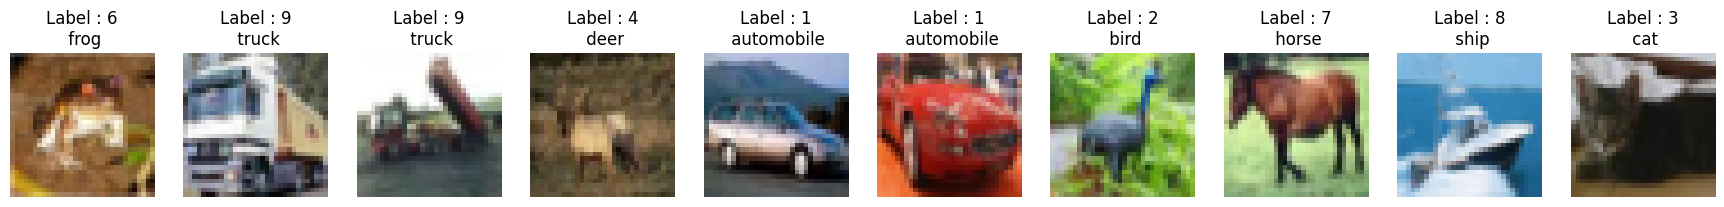

In [ ]:
# Cifar10 이미지 확인

# == train에 대한 label 뽑기 ==
train_labels_dict = train.class_to_idx
train_labels_dict = dict(zip(train_labels_dict.values(), train_labels_dict.keys()))

# == 10개의 train 봐보기 ==
train_images, train_labels = train.data[:10], train.targets[:10]

# == img들 볼 수 있는 함수 ==
def show_img(img, label, count = 10, flag = True):
  figure, axs = plt.subplots(figsize = (22, 6), nrows = 1, ncols = count)

  for i in range(count):
    axs[i].imshow(img[i])

    # == Train ==
    if flag == True:
      axs[i].set_title(f"Label : {train_labels[i]}\n {train_labels_dict[train_labels[i]]}")

    # == Test ==
    elif flag == False:
      axs[i].set_title(f"Label : {test_labels[i]}\n {test_labels_dict[test_labels[i]]}")

    axs[i].axis('off')

# == train 이미지 확인==
show_img(train_images,train_labels, count = 10, flag = True)

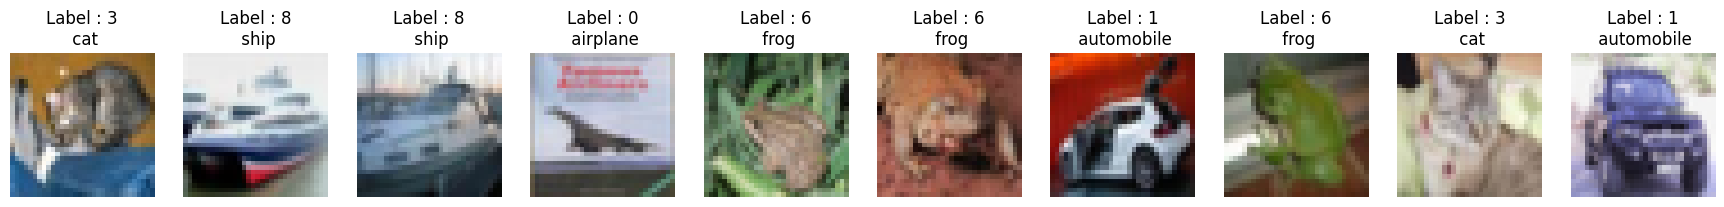

In [ ]:
# Cifar 10 이미지 확인

# == test에 대한 label 뽑기 ==
test_labels_dict = test.class_to_idx
test_labels_dict = dict(zip(test_labels_dict.values(), test_labels_dict.keys()))

# == 10개의 test 봐보기 ==
test_images, test_labels = test.data[:10], test.targets[:10]

# == test 이미지 확인 ==
show_img(test_images, test_labels, count = 10, flag = False)


# 데이터 전처리

In [ ]:
train, test = get_data()

train.transform = transforms.ToTensor()
test.transform = transforms.ToTensor()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# == 이미지의 전처리 작업으로 Image의 각 channel의 평균값을 빼주었다고 한다. ==

# == 이미지 전처리 ==

# == Train ==

meanRGB_train = [np.mean(x.numpy(), axis = (1, 2)) for x, _ in train] # criterion by row, column --> become RGB mean
stdRGB_train = [np.std(x.numpy(), axis = (1, 2)) for x, _ in train]

meanRGB_test = [np.mean(x.numpy(), axis = (1, 2)) for x, _ in test] # criterion by row, column --> become RGB mean
stdRGB_test = [np.std(x.numpy(), axis = (1, 2)) for x, _ in test]

meanR_train = np.mean([m[0] for m in meanRGB_train])
meanG_train = np.mean([m[1] for m in meanRGB_train])
meanB_train = np.mean([m[2] for m in meanRGB_train])

stdR_train = np.mean([s[0] for s in stdRGB_train])
stdG_train = np.mean([s[1] for s in stdRGB_train])
stdB_train = np.mean([s[2] for s in stdRGB_train])

mean_train = [meanR_train, meanG_train, meanB_train]
std_train = [stdR_train, stdG_train, stdB_train]

# == Test ==
meanR_test = np.mean([m[0] for m in meanRGB_test])
meanG_test = np.mean([m[1] for m in meanRGB_test])
meanB_test = np.mean([m[2] for m in meanRGB_test])

stdR_test = np.mean([s[0] for s in stdRGB_test])
stdG_test = np.mean([s[1] for s in stdRGB_test])
stdB_test = np.mean([s[2] for s in stdRGB_test])

mean_test = [meanR_test, meanG_test, meanB_test]
std_test = [stdR_test, stdG_test, stdB_test]

print(' == == == == Train == == == ==')
print('각 Channel당 pixel Mean 값 : ', mean_train)
print('각 Channel당 pixel Std 값 : ', std_train)
print(' == == == == == == == == == ==')

print(' == == == == Test == == == ==')
print('각 Channel당 pixel Mean 값 : ', mean_test)
print('각 Channel당 pixel Std 값 : ', std_test)
print(' == == == == == == == == == ==')

 == == == == Train == == == ==
각 Channel당 pixel Mean 값 :  [0.49139965, 0.48215845, 0.4465309]
각 Channel당 pixel Std 값 :  [0.20220213, 0.19931543, 0.20086348]
 == == == == == == == == == ==
 == == == == Test == == == ==
각 Channel당 pixel Mean 값 :  [0.49421427, 0.48513138, 0.45040908]
각 Channel당 pixel Std 값 :  [0.20189482, 0.19902097, 0.20103233]
 == == == == == == == == == ==


In [ ]:
'''
== train loader & augmentation ==
1. cifar10의 size는 32x32이기 때문에 256x256으로 resize를 해주는 것이 아닌 28x28로 resize
2. Random crop : 무작위로 자르는 데 사용
3. Translation : 각도는 변하지 않고, 수평,수직 방향으로 최대 10%로 이동할 수 있게끔 한다.
4. Horizontal flip : 50%로 수평변환
5. Normalization : mean값 각 channel의 평균값을 빼주기, std에 대한 이야기는 없었음
6. PCA가 있긴함.

== test loader &  ==
1. 28x28로 resize
2. Normalization
'''
train_loader = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256)),
    transforms.CenterCrop((227)),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Normalize(mean_train, std_train)

])

test_loader = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227)),
    transforms.Normalize(mean_test, std_test)
])
train.transform = train_loader
test.transform = test_loader

# 모델 설계

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Alex(nn.Module):
  def __init__(self):
    super(Alex, self).__init__()

    # input size : 3 * 227 * 227

    # Conv Layer
    self.conv = nn.Sequential(

        # Layer 1
        nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 11, stride = 4, padding = 0),
        # nn.BatchNorm2d(96),
        nn.ReLU(inplace = True),
        nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75, k = 2),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        # Layer 2
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # (b x 256 x 27 x 27)
        # nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        # Layer 3
        nn.Conv2d(256, 384, 3, 1, 1),
        nn.ReLU(),

        # Layer 4
        nn.Conv2d(384, 384, 3, 1, 1),
        nn.ReLU(),

        # Layer 5
        nn.Conv2d(384, 256, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )

    self.fc = nn.Sequential(

        # Fc 1
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),

        # Fc 2
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),

    )

    # == output ==
    # nn.Linear(4096, 10)
    self.outlayer = nn.Linear(4096, 10)

  # weight initialized(합성곱, 연결층은 he가중치, output만 xavier 기법, bias는 0으로 초기화)
  def init_weight(self):
      for layer in self.modules():
          if isinstance(layer, (nn.Conv2d, nn.Linear)):
              nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
      nn.init.xavier_uniform_(self.outlayer.weight)

  # model sequence
  def forward(self, x):
    out = self.conv(x)

    # flatten
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    out = self.outlayer(out)

    return out

In [ ]:
# == 모델 봐보기 ==

model = Alex().to(device)
model.init_weight()

weights_path = '/content/drive/MyDrive/딥러닝_입문/best_weight_AlexNet_first.pth'


# 저장된 가중치 불러오기
model.load_state_dict(torch.load(weights_path))


torchsummary.summary(model, input_size = (3, 227, 227), device = 'cuda')

RuntimeError: ignored

In [ ]:
model.state_dict()

OrderedDict([('conv.0.weight',
              tensor([[[[-2.5958e-02,  4.2887e-03, -1.2215e-01,  ..., -6.9671e-02,
                          1.0532e-01, -9.8137e-02],
                        [-1.0922e-01, -2.3342e-02,  1.1830e-01,  ...,  1.1666e-02,
                          8.4832e-02, -7.4584e-02],
                        [ 6.9020e-02, -1.8258e-02, -7.4137e-02,  ..., -6.5006e-02,
                          5.2148e-02,  6.4130e-02],
                        ...,
                        [-6.2177e-02, -3.3870e-02,  3.1855e-02,  ...,  1.0152e-01,
                         -6.6273e-02,  3.5778e-02],
                        [ 7.4127e-02,  4.1689e-02,  9.8154e-02,  ...,  5.0652e-02,
                          7.7672e-02,  2.3310e-02],
                        [-1.0695e-01,  7.0813e-02, -8.6717e-02,  ..., -1.1061e-01,
                          1.8632e-02, -1.0663e-01]],
              
                       [[ 3.5675e-02, -1.0054e-01,  3.6917e-02,  ...,  8.7384e-02,
                         -1.566

# 훈련&검증

In [ ]:
# == train : 80%, validation : 20% ==

train_ratio = 0.8
val_ratio = 0.2

train_size = int(len(train) * train_ratio)
val_size = len(train) - train_size

split_train, split_val = random_split(train, [train_size, val_size])

In [ ]:
# == 논문 그대로 설정 ==
batch_size = 128
learning_rate = 0.01
epochs = 10 # for real, epoch = 90
momentum = 0.9
weight_decay = 0.0005

In [ ]:
# == 최적화, 손실함수 ==
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = split_train,
                                           batch_size=  batch_size,
                                           shuffle = True,
                                           drop_last = True)

val_loader = torch.utils.data.DataLoader(dataset = split_val,
                                        batch_size = batch_size,
                                        shuffle = True,
                                        drop_last = True)

In [ ]:
total_batch = len(train_loader)

print('Weight update 횟수 : ', total_batch)

Weight update 횟수 :  312


In [ ]:
# == Confusion Matrix ==
y_true = []
y_pred = []

# == Loss ==
train_losses = []
validation_losses = []

# == Accuracy ==
train_accuracy = []
validation_accuracy = []

# == Weight 저장 ==
best_model_path = "best_weight_AlexNet_first.pth"
best_accuracy = 0.0

In [ ]:
train_losses = []
validation_losses = []

train_accuracy = []
validation_accuracy = []

# == 학습 진행 ==
for epoch in range(epochs):
    # == 모델을 학습 모드로 설정 ==
    model.train()
    '''
    1. for문 1번 반복할때마다 batch_idx는 batch_size만큼 증가
     ex) 1 iter: 0 ~ 127
         2 iter: 128 ~ 255
         전체 훈련 데이터를 다 쓰기전까지 반복.
    '''


    # train loss 변수
    running_train_loss = 0.0

    correct_train = 0
    total_train = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # 데이터와 레이블을 GPU로 이동 (if available)
        data, target = data.to(device), target.to(device)

        # Forward 연산
        output = model(data)

        # Confusion Matrix
        _, predicted = torch.max(output, 1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        # 손실 계산
        loss = criterion(output, target)

        # Backward 연산 및 매개변수 업데이트
        optimizer.zero_grad() # 미분값 중복 방지
        loss.backward() # 오차역전파
        optimizer.step() # parameter 업데이트

        # train loss 담기
        running_train_loss += loss.item()

        # 일정 간격으로 손실 출력
        if batch_idx % 100 == 0:
            #print(len(train_loader)) 항상 312로 동일한 값
            print(batch_idx)
            print('Epoch {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) # 100.은 실수형을 말한다.(실수형으로 출력하기 위함)
                # len(train_loader)는 배치 개수를 나타낸다. 여기서는 312개(312번 가중치 update)

        pred_train = output.argmax(dim=1, keepdim=True)
        correct_train += pred_train.eq(target.view_as(pred_train)).sum().item()
        total_train += data.size(0)  # 현재 배치의 데이터 수를 더함

    # 전체 훈련 데이터에 대한 정확도 계산 및 저장
    accuracy_train = 100. * correct_train / total_train
    train_accuracy.append(accuracy_train)  # train accuracy 기록

    # train loss 기록
    train_loss = running_train_loss / len(train_loader) # 모든 batch의 평균 훈련 손실
    train_losses.append(train_loss)


    # == 검증 데이터셋을 사용한 모델 평가 ==

    # ==  모델을 평가 모드로 설정 ==
    model.eval()
    val_loss = 0
    correct = 0

    # == 미분값 계산 x ==
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            # Forward 계산
            output = model(data)

            val_loss += criterion(output, target).item() # 손실함수 계산
            pred = output.argmax(dim=1, keepdim=True) # 예측값(행마다)에서 가장 큰 값의 인덱스 가져옴, (n, 1)형식
            correct += pred.eq(target.view_as(pred)).sum().item() # target을 pred와 같은 shape으로 만들어준다.
            '''
            .eq()는 두 tensor의 shape이 동일해야 비교 연산이 가능하다.
            '''
    validation_losses.append(val_loss / len(val_loader)) # validation loss 기록
    val_loss /= len(val_loader.dataset) # 검증 손실함수
    val_accuracy = 100. * correct / len(val_loader.dataset) # 검증 정확도

    # == 가중치 저장 ==
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Weight Updated {best_accuracy}")
    validation_accuracy.append(val_accuracy) # validation accuracy 기록


    # == 검증 결과 출력 ==
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), val_accuracy))

0
Epoch 1 [0/40000 (0%)]	Loss: 3.818360
100
Epoch 1 [12800/40000 (32%)]	Loss: 1.808471
200
Epoch 1 [25600/40000 (64%)]	Loss: 1.663924
300
Epoch 1 [38400/40000 (96%)]	Loss: 1.517647
Weight Updated 49.38

Validation set: Average loss: 0.0110, Accuracy: 4938/10000 (49.38%)

0
Epoch 2 [0/40000 (0%)]	Loss: 1.471814
100
Epoch 2 [12800/40000 (32%)]	Loss: 1.474252
200
Epoch 2 [25600/40000 (64%)]	Loss: 1.276117
300
Epoch 2 [38400/40000 (96%)]	Loss: 1.279165
Weight Updated 54.96

Validation set: Average loss: 0.0098, Accuracy: 5496/10000 (54.96%)

0
Epoch 3 [0/40000 (0%)]	Loss: 1.196815
100
Epoch 3 [12800/40000 (32%)]	Loss: 1.232439
200
Epoch 3 [25600/40000 (64%)]	Loss: 1.056362
300
Epoch 3 [38400/40000 (96%)]	Loss: 1.117562
Weight Updated 60.29

Validation set: Average loss: 0.0087, Accuracy: 6029/10000 (60.29%)

0
Epoch 4 [0/40000 (0%)]	Loss: 1.202118
100
Epoch 4 [12800/40000 (32%)]	Loss: 1.068557
200
Epoch 4 [25600/40000 (64%)]	Loss: 0.981681
300
Epoch 4 [38400/40000 (96%)]	Loss: 1.040522
Wei

# 모델 테스트

In [ ]:
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1) # 가장 높은값의 인덱스, 값 반환 --> 여기서는 가장 높은 값만 반환했다.

    total += labels.size(0) # 전체 데이터 예측 개수(len(cifar_test_loader) 와 같다)
    correct += (predicted == labels.to(torch.long)).sum().item() # predicted, labels의 텐서 타입이 일치하지 않아서 long으로 바꾸어줌.
    # 맞으면 correct에 true, 틀리면 false 반환한다. 맞은 것만 개수 센다.

accuracy = 100 * correct / total
print(f'Accuracy : {accuracy}')

Accuracy : 77.96


# Confusion Matrix 구현

In [ ]:
# == Confusion Matrix 출력 ==
conf_matrix = confusion_matrix(y_true, y_pred)

print('Confusion Matrix : ')
print(conf_matrix)

Confusion Matrix : 
[[26615  1531  2469   886   741   405   366   780  4446  1826]
 [ 1272 31473   331   397   175   214   473   301  1586  4051]
 [ 3122   555 20670  2999  3952  2478  3268  1747   875   694]
 [  959   410  3020 18913  2198  7311  3435  1801   852   932]
 [ 1309   339  3695  2479 22711  1789  3265  3457   397   441]
 [  443   339  2346  7742  2036 21811  1676  2601   377   611]
 [  311   412  2553  3057  2554  1249 28379   654   388   568]
 [  650   333  1551  2223  3006  2943   721 26684   346  1050]
 [ 4067  1513   611   741   254   311   346   248 29843  1761]
 [ 1528  4323   374   794   219   367   559   861  1665 28950]]


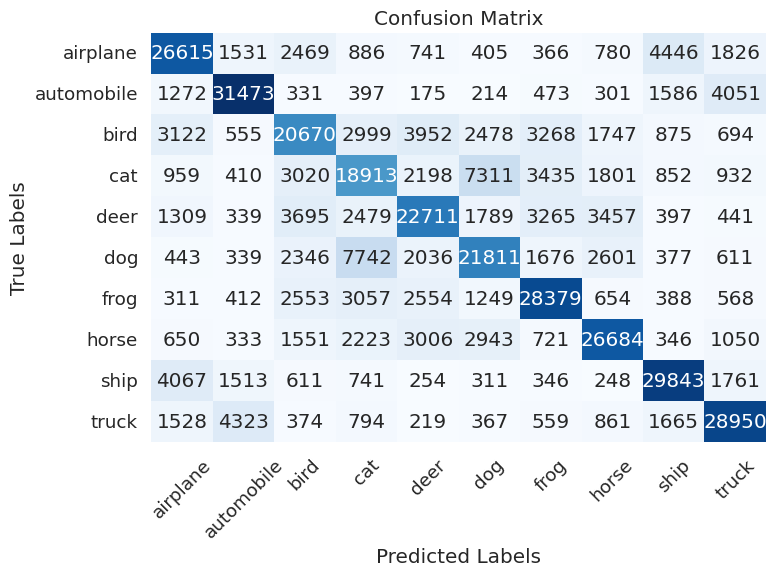

'\n1. Recall\n2. Precision\n3. F1-score 구해보기\n\n\n'

In [ ]:
# 클래스의 이름을 정의 (CIFAR-10의 경우)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Confusion matrix 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # 폰트 크기 설정

# Confusion matrix 히트맵 생성
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


'''
1. Recall
2. Precision
3. F1-score 구해보기


'''

# train_loss와 validation_loss 시각화

In [ ]:
def loss_visualization(train_loss, val_loss):

  plt.figure(figsize = (8, 6))
  plt.plot(train_losses, label = 'train_loss', marker = 'o')
  plt.plot(val_loss, label = 'val_loss', marker = 's')
  plt.title('Train Loss & Validaiton Loss')
  plt.xticks(np.arange(1, len(train_loss) + 1))  # 수정된 부분
  plt.xlabel('Epoch')
  plt.ylabel('Loss(Cross Entropy)')
  plt.legend()
  plt.tight_layout()
  plt.show()

In [ ]:
loss_visualization(train_losses, validation_losses)


'''
overfitting 나지 않음

'''

NameError: ignored

# train_accuracy와 validation_accuracy 시각화

In [ ]:
def acc_visualization(train_acc, val_acc):
  plt.figure(figsize = (8, 6))
  plt.plot(train_acc, label = 'train_acc', marker = 'o', ls = '--')
  plt.plot(val_acc, label = 'val_acc', marker = 's')
  plt.title('Train Accuracy & Validaiton Accuracy')
  plt.xticks(np.arange(0, epochs, step=max(1, epochs // 10)))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

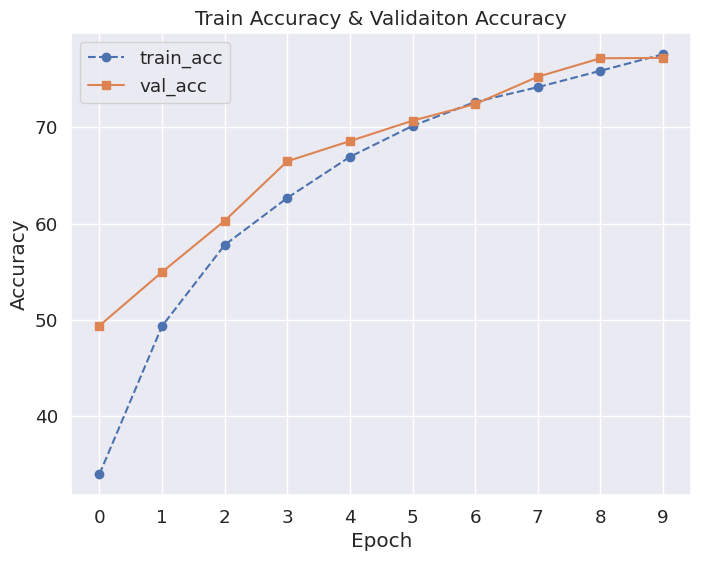

'\noverfitting x\n\n'

In [ ]:
acc_visualization(train_accuracy, validation_accuracy)

'''
overfitting x

'''

# PCA 코드를 통해서 class별 embedding space 표현

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # PCA는 Normalization하면 좌표로 더 잘볼 수 있다.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


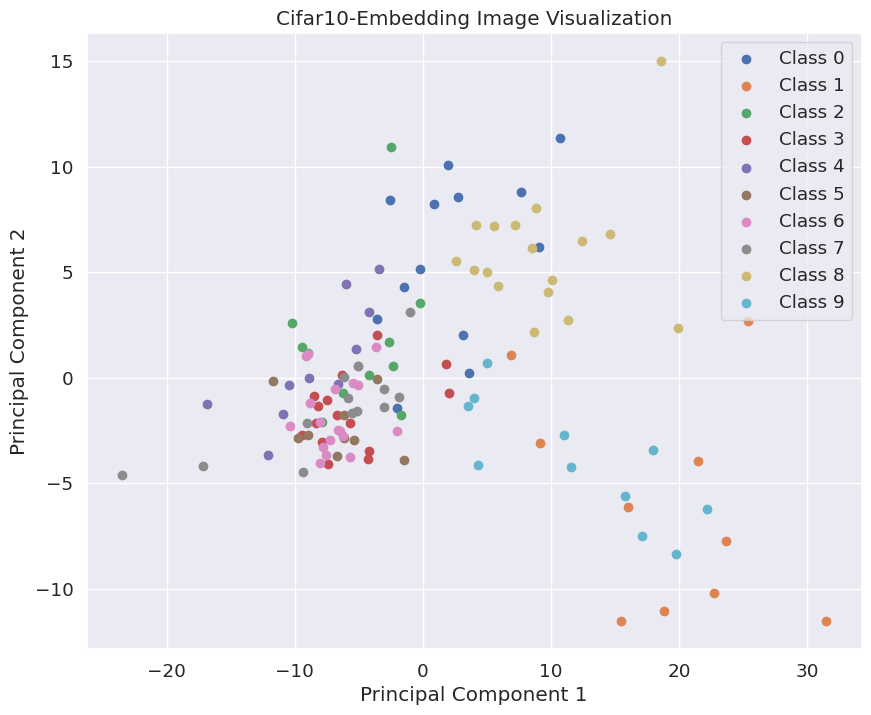

In [ ]:
def custom_PCA(data, n_components=2):
    # 데이터의 평균 계산
    mean = np.mean(data, axis=0)

    # 중심화된 데이터 행렬 생성
    centered_data = data - mean

    # 공분산 행렬 계산
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # SVD를 사용하여 공분산 행렬 분해
    U, S, V = np.linalg.svd(covariance_matrix)

    # 주성분(PC) 선택 (2차원으로 축소)
    principal_components = U[:, :n_components]

    # 데이터에 주성분 투영하여 2차원으로 축소
    pca_result = np.dot(centered_data, principal_components)

    return pca_result

model.eval()

images, labels = next(iter(test_loader))
images = images.to(device)  # 이미 GPU로 로드된 모델의 가중치와 동일한 장치로 데이터 이동
labels = labels.numpy()

# AlexNet을 통과한 후의 특성 추출
with torch.no_grad():
    outputs = model(images)

outputs_numpy = outputs.cpu().numpy()

# Embedding space를 더 잘보기 위함
scaler = StandardScaler()
outputs_numpy_standardized = scaler.fit_transform(outputs_numpy)

# PCA 함수 적용
pca_result = custom_PCA(outputs_numpy)

# 시각화 (이하 동일)
plt.figure(figsize=(10, 8))

for i in range(10):
    indices = np.where(labels == i)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Class {i}')
plt.legend()
plt.title('Cifar10-Embedding Image Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()